# Teste 1 - Python

        Tentando importar e utilizar os dados do Ministério da Saúde em https://covid.saude.org.br para avaliar a situação divulgada oficialmente pelo MS; 
        A url muda diariamente, há uma série de caracteres em primeira vista aleatórios que é atualizada também todo dia... como puxar o arquivo csv automaticamente?
        O site não disponibiliza dados de SRAG, apenas uma tabela repetida do COVID desatualizada.
        Nova tabela com dados do Brasil (população)
         Dados de SRAG da fiocruz em padrão brasileiro (109,0009) como transformar o arquivo em padrão americano/internacional (109.0009) automaticamente pela URL?

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado
        
        Mostrar dados de SRAG e comparar com o aumento dos números confirmados de COVID
        Dados em semana epidemiológica

## Estimativas (Regressão)
        
        Estimar próximos números (até 7 dias?) utilizando 2, 3 ou 4 (todos?) dias anteriores e regressão não linear
        Estimar curvas com ajuda dos dados de SRAG inconclusivos (qual a porcentagem de testes incompletos espera-se que serão confirmados)
        
## Modelo de Contágio

        Utilizar dados adquiridos para rodar um modelo epidemiológico que utiliza valores de reprodução base e evolução da COVID-19, causada pelo vírus SARS-COV-2
  

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

url_B = "https://raw.githubusercontent.com/Yannngn/COVID19-04-20/master/brasil.csv"
url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/2c5ba231bf85449a2cd700735e469452_Download_COVID19_20200425.csv"

In [2]:
brasil = pd.read_csv(url_B, sep = ';')
df = pd.read_csv(url_C, sep = ";")

In [3]:
FMT = '%Y-%m-%d'

date = df['data']
regi = df['regiao']

df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)


In [4]:
df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos', 'estado']]
df_UF = df.loc[:, ['estado', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

In [5]:
df1 = df1.groupby("data").sum()

# total of days since 2020-01-30 - x
x = list(df1.index)

In [6]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    np.random.seed(19)
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return [a, b]

In [7]:
# total cases
x = list(df1.index)
y = list(df1.iloc[:, 0])

exp_p = exp_param([y[-1], y[-2], y[-4]], [x[-1], x[-2], x[-4]])
exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1], bounds = (0, df.index.size))
#exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], 
                                                          exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))
exponential_errors = [np.sqrt(exponential_fit[1][i][i]) for i in [0, 1, 2]]
exponential_errors

C:\Users\calad\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


[1588488.1889571177, 0.0015689584151510224, 398245.3629494616]

In [8]:
# new cases
y = list(df1.iloc[:, 1])

exp_p = exp_param([y[-1], y[-2], y[-4]], [x[-1], x[-2], x[-4]])
new_exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1], bounds = (0, df.index.size))
new_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_exponential_fit[0][0],
                                                              new_exponential_fit[0][1], 
                                                              new_exponential_fit[0][2]) - int(new_exponential_fit[0][2]), new_exponential_fit[0][1]))
new_exponential_errors = [np.sqrt(new_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_exponential_errors

[23056566.055402823, 0.004506165114782419, 13100349.946300633]

In [9]:
# total deaths
y = list(df1.iloc[:, 2])

exp_p = exp_param([y[-1], y[-2], y[-4]], [x[-1], x[-2], x[-4]])
death_exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1], bounds = (0, df.index.size))
death_exponential_sol = int(fsolve(lambda x : exponential_model(x, death_exponential_fit[0][0],
                                                                death_exponential_fit[0][1], 
                                                                death_exponential_fit[0][2]) - int(death_exponential_fit[0][2]), death_exponential_fit[0][1]))
death_exponential_errors = [np.sqrt(death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
death_exponential_errors

[66970.87969601629, 0.0019003588332790697, 595475.1859510797]

In [10]:
# new deaths
y = list(df1.iloc[:, 3])

exp_p = exp_param([y[-1], y[-2], y[-4]], [x[-1], x[-2], x[-4]])
#new_death_exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1], bounds = (0, df.index.size))
new_death_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
new_death_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_death_exponential_fit[0][0], 
                                                                    new_death_exponential_fit[0][1], 
                                                                    new_death_exponential_fit[0][2]) - int(new_death_exponential_fit[0][2]), new_death_exponential_fit[0][1]))
new_death_exponential_errors = [np.sqrt(new_death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_death_exponential_errors

[426132411.02928203, 0.005914084144989385, 65770828.86070774]

## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [11]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

a0 = 1.7

b0 = df1.index.size + 31
b1 = b0 + 14

pBrasil = brasil.at[brasil['UF'].eq('BR').idxmax(),'População']
c0 = 0.4 * pBrasil
c1 = 0.04 * pBrasil
c2 = 0.02 * c0
c3 = 0.001 * c2

In [12]:
# total cases
y = list(df1.iloc[:, 0])

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c0])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
logistic_errors = [np.sqrt(logistic_fit[1][i][i]) for i in [0, 1, 2]]
logistic_errors

[0.185808915588949, 0.7060939837093629, 4009.3135834570885]

In [13]:
# new cases
y = list(df1.iloc[:, 1])

new_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c1])
new_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_logistic_fit[0][0], new_logistic_fit[0][1], 
                                                        new_logistic_fit[0][2]) - int(new_logistic_fit[0][2]), new_logistic_fit[0][1]))
new_logistic_errors = [np.sqrt(new_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_logistic_errors

[2.448295854173521, 172.8372238038009, 1581240.7551546893]

In [14]:
# total deaths
y = list(df1.iloc[:, 2])

death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c2])
death_logistic_sol = int(fsolve(lambda x : logistic_model(x, death_logistic_fit[0][0], death_logistic_fit[0][1], 
                                                          death_logistic_fit[0][2]) - int(death_logistic_fit[0][2]), death_logistic_fit[0][1]))
death_logistic_errors = [np.sqrt(death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
death_logistic_errors

[0.20970061512172017, 0.7891287407984506, 356.86102467183775]

In [15]:
# new deaths
y = list(df1.iloc[:, 3])
a0, b1, c3
new_death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c3])
new_death_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_death_logistic_fit[0][0], new_death_logistic_fit[0][1], 
                                                               new_death_logistic_fit[0][2]) - int(new_death_logistic_fit[0][2]), new_death_logistic_fit[0][1]))
new_death_logistic_errors = [np.sqrt(new_death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_death_logistic_errors

[1.7071635521767298e+21, 5.9181014555566914e+28, 5.9063306682361235e+31]


# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

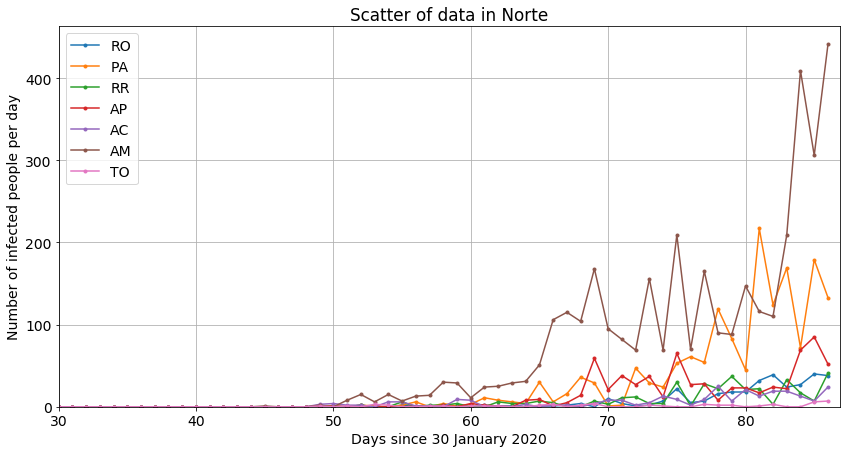

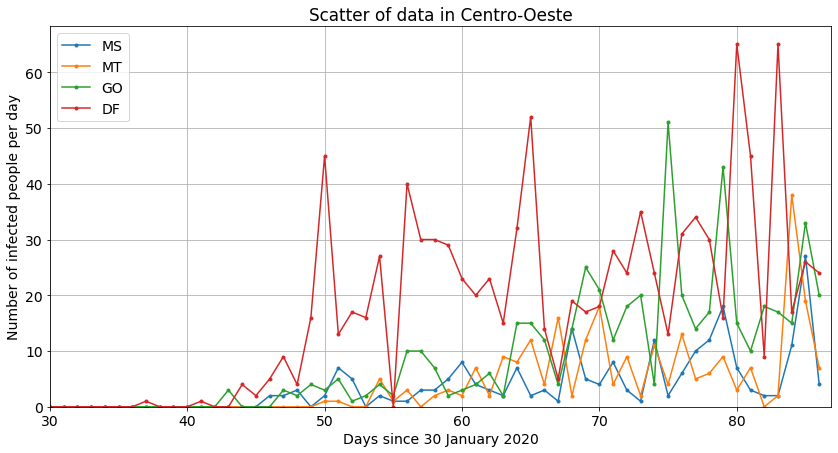

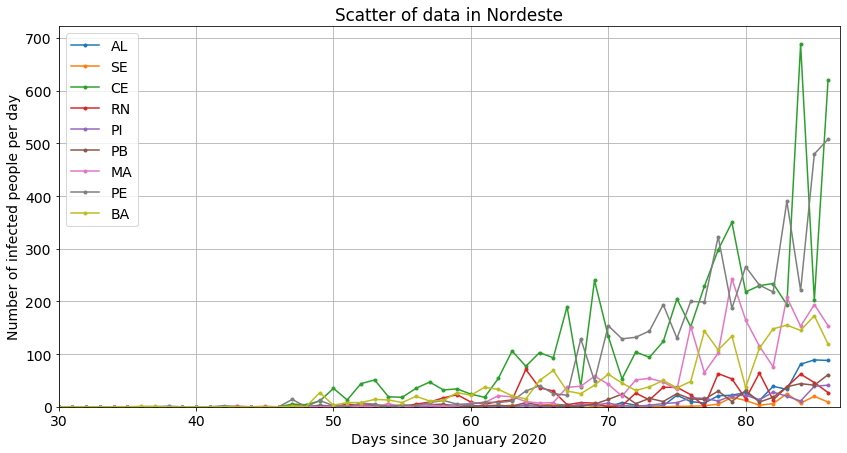

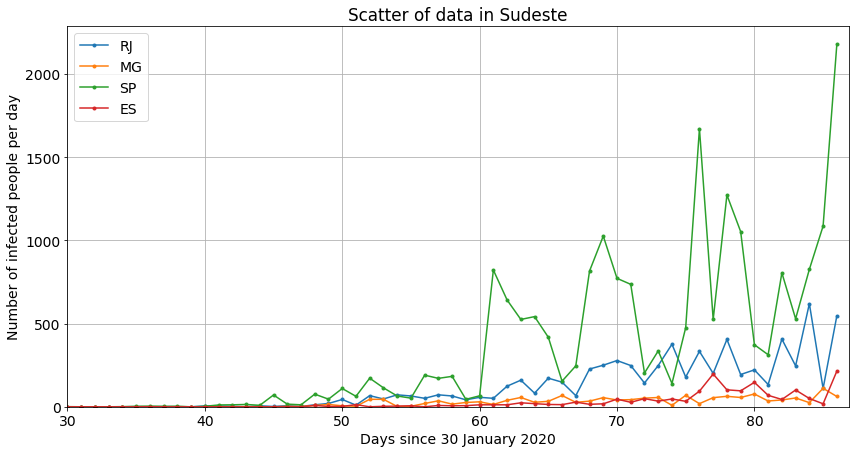

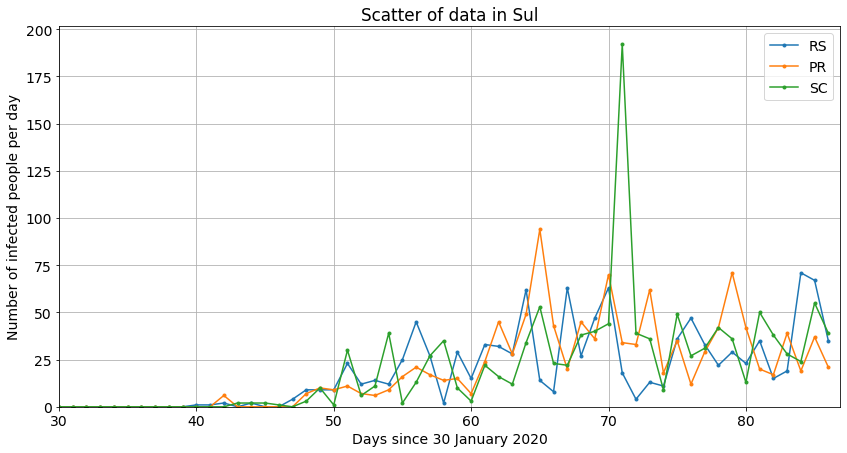

In [16]:
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

dfs = dfs.sort_values("data")
y = list(dfs.iloc[:, 3])

# Real data
# Brazilian areas separated

regioes = dfs["regiao"].unique()
estados = list(dfs["estado"].unique())

for r in regioes : 
    plt.grid(True)
    for e in estados :
        yx = max(dfs[dfs['regiao'] == r].iloc[:, 3])
        uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Regiao"]
        if uf == r :
            xs = list(dfs[dfs['estado'] == e].iloc[:, 1])
            ys = list(dfs[dfs['estado'] == e].iloc[:, 3])
            plt.plot(xs, ys, marker = '.', label = e)
    plt.title("Scatter of data in " + r)
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Number of infected people per day")
    plt.xlim(30, max(xs) * 1.01)
    plt.ylim(0, yx * 1.05)
    plt.show()


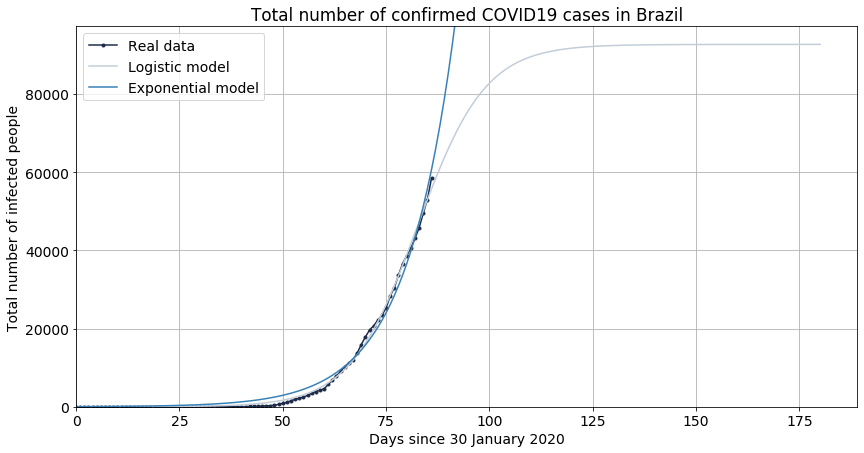

Expected final values: end of spread in 94 days, with 92649.513 cases in Brazil


In [17]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), logistic_sol))
y = list(df1.iloc[:, 0])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of confirmed COVID19 cases in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of infected people")
plt.xlim(0, max(pred_x) * 1.05)
plt.ylim(0, logistic_fit[0][2] * 1.05)
plt.show()
print("Expected final values: end of spread in " + str(max(pred_x) - max(x)) + " days, with " + str(round(logistic_fit[0][2], 3)) + " cases in Brazil")

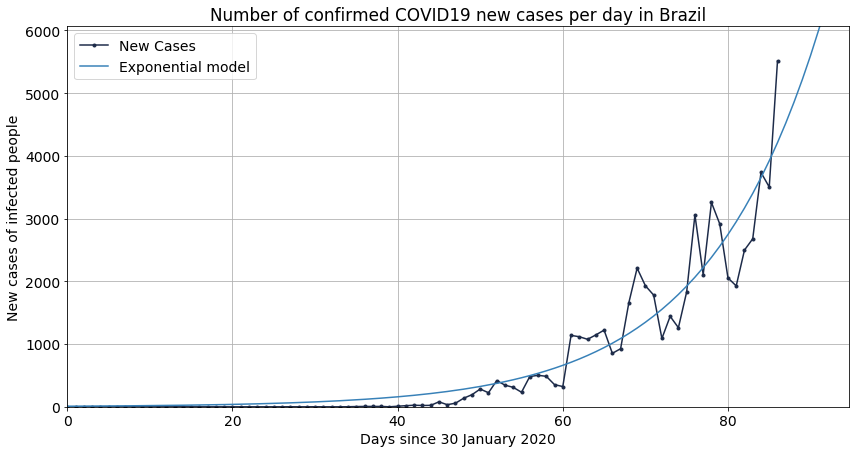

Next number of confirmed new cases is 4522.064


In [18]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), new_logistic_sol))
y = list(df1.iloc[:, 1])

plt.plot(x, y, marker = '.', label = "New Cases", color="#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_exponential_fit[0][0], new_exponential_fit[0][1], new_exponential_fit[0][2])
                    for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of confirmed COVID19 new cases per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New cases of infected people")
plt.ylim(0, max(y) * 1.1)
plt.xlim(0, max(x) * 1.1)
plt.show()
print("Next number of confirmed new cases is "+ str(round(exponential_model(max(x) + 1, new_exponential_fit[0][0], new_exponential_fit[0][1], new_exponential_fit[0][2]), 3)))

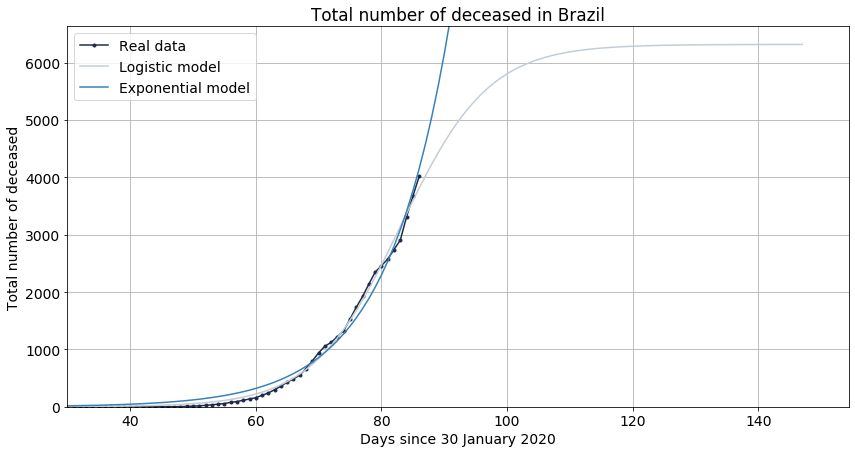

Expected final values: end of spread in 61 days, with 6319.538 deceased in Brazil


In [19]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))

y = list(df1.iloc[:, 2])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, death_logistic_fit[0][0], death_logistic_fit[0][1], death_logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, death_exponential_fit[0][0], death_exponential_fit[0][1], death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of deceased in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of deceased")
plt.xlim(30, max(pred_x) * 1.05)
plt.ylim(0, death_logistic_fit[0][2] * 1.05)
plt.show()
print("Expected final values: end of spread in " + str(max(pred_x) - max(x)) + " days, with " + str(round(death_logistic_fit[0][2], 3)) + " deceased in Brazil")

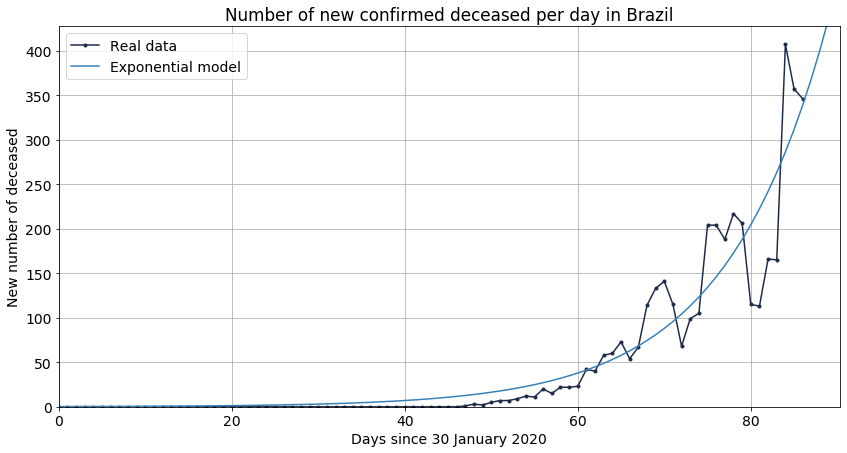

Next number of confirmed is 368.593


In [20]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))
y = list(df1.iloc[:, 3])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_death_exponential_fit[0][0], new_death_exponential_fit[0][1], new_death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of new confirmed deceased per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New number of deceased")
plt.xlim(0, max(x) * 1.05)
plt.ylim(0, max(y) * 1.05)
plt.show()
print("Next number of confirmed is "+ str(round(exponential_model(max(x) + 1, new_death_exponential_fit[0][0], new_death_exponential_fit[0][1], new_death_exponential_fit[0][2]), 3)))

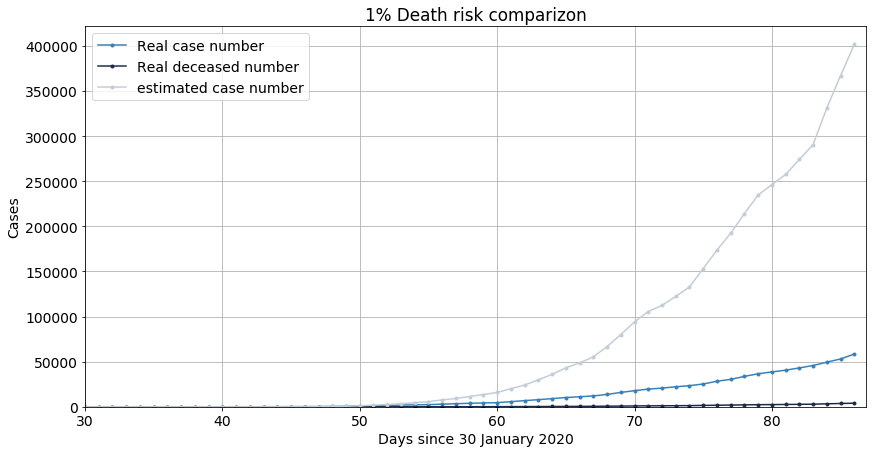

Expected actual value is: 401600 in day 86


In [21]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data

y = list(df1.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df1.iloc[:, 2])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df1.iloc[:, 2].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.xlim(30, max(x) * 1.01)
plt.ylim(0, max(y) * 1.05)
plt.show()
print("Expected actual value is: " + str(max(y)) + " in day " + str(max(x)))

## Casos Totais por estado
    
    Casos confirmados x tempo
    
    Dados reais, estimativa exponencial e em estados com mais de 1000 casos estimativa logistica
    
    Os dados são subnotificados e possuem baixa confiabilidade

Next number of confirmed is 398.68 in RO


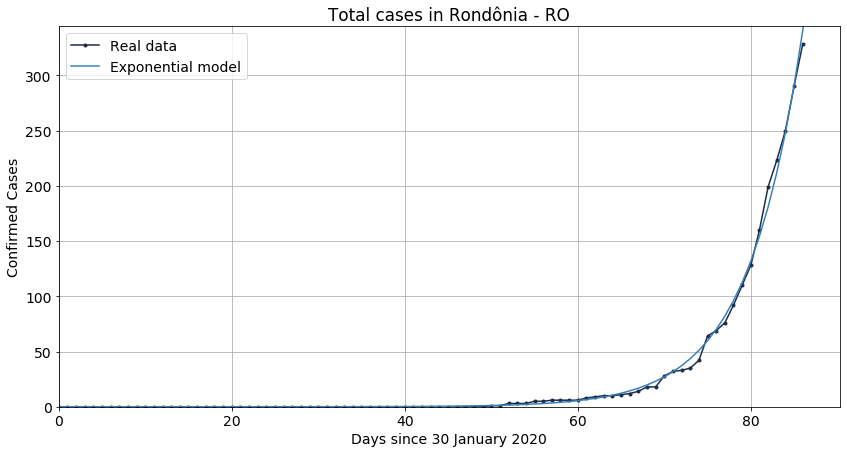

Next number of confirmed is 247.817 in MS


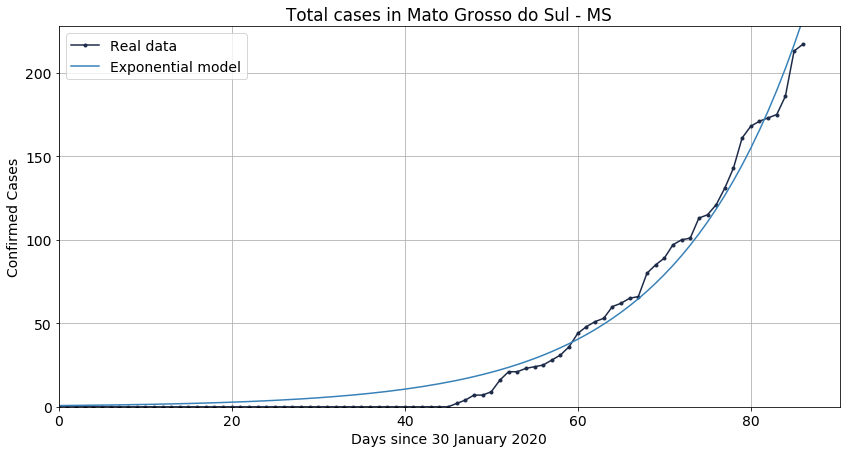

Expected final values: end of spread in 136 days with 3755.391 cases in PA
Next number of confirmed is 1930.649 in PA


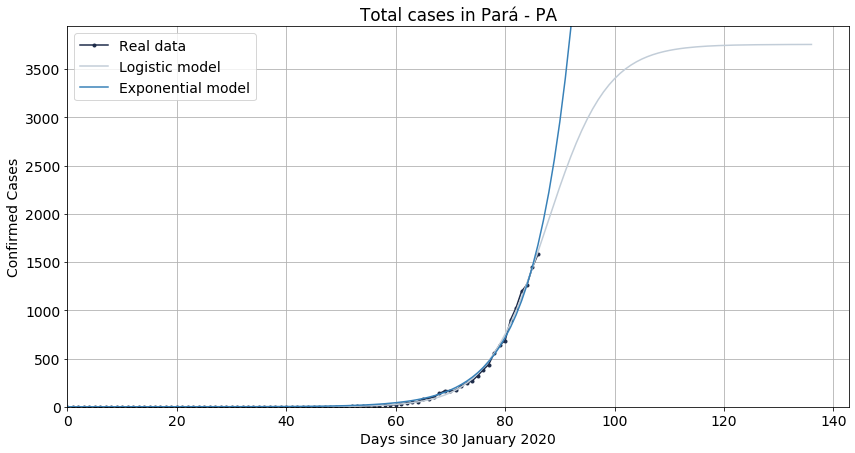

C:\Users\calad\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Next number of confirmed is 576.671 in AL


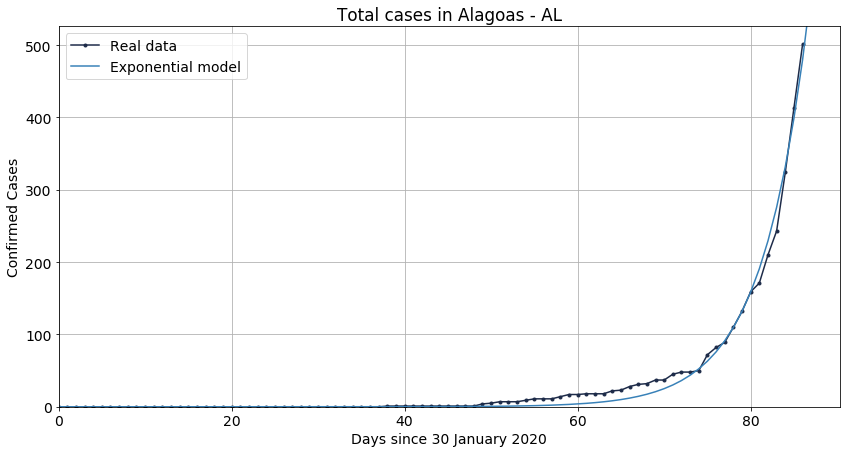

Next number of confirmed is 159.129 in SE


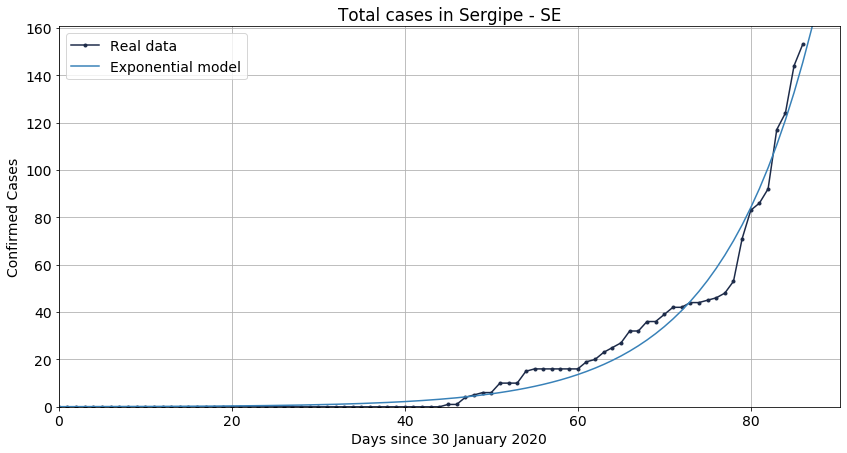

Expected final values: end of spread in 174 days with 14338.942 cases in CE
Next number of confirmed is 6001.3 in CE


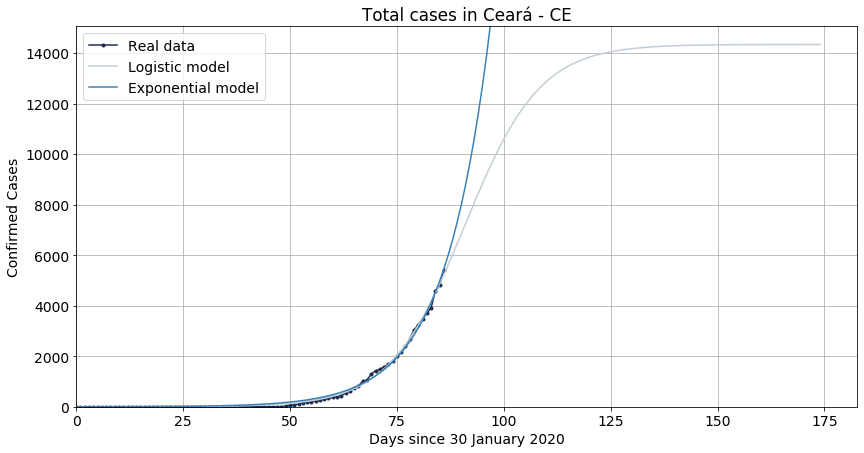

Expected final values: end of spread in 150 days with 9121.583 cases in RJ
Next number of confirmed is 7950.228 in RJ


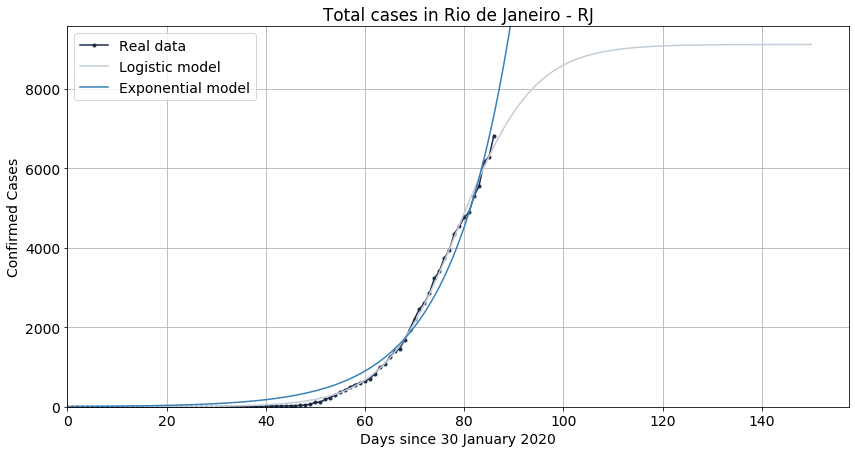

Next number of confirmed is 411.924 in RR


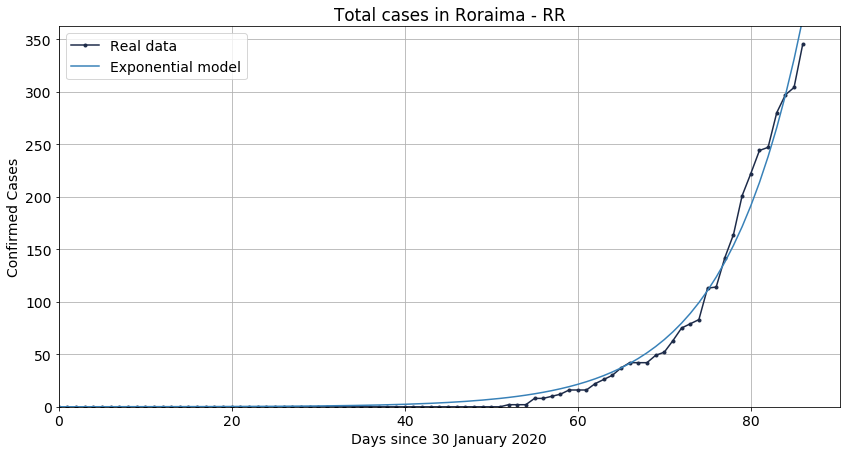

Next number of confirmed is 287.488 in MT


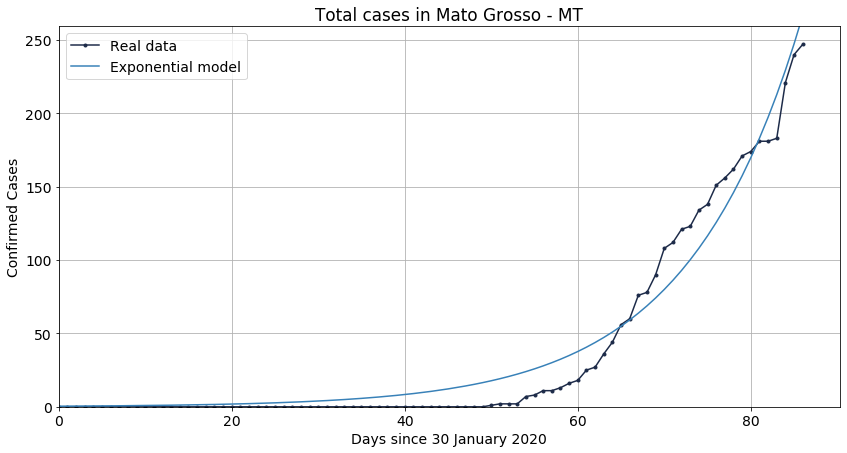

Expected final values: end of spread in 132 days with 1117.215 cases in RS
Next number of confirmed is 1293.325 in RS


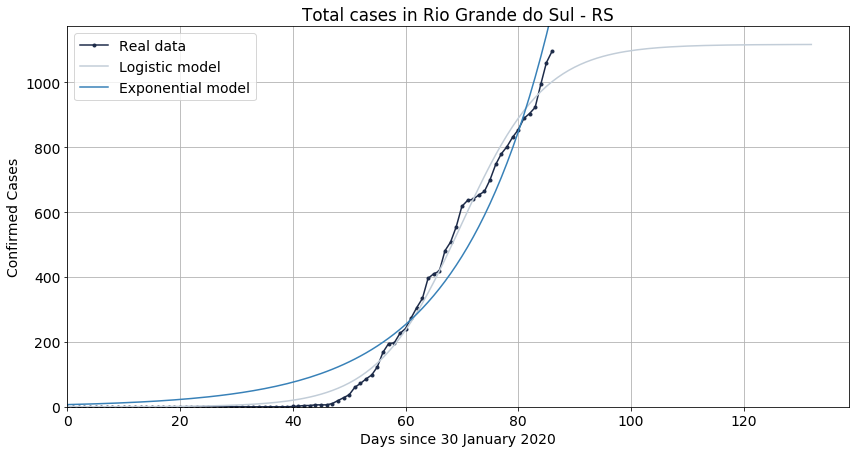

Next number of confirmed is 797.666 in AP


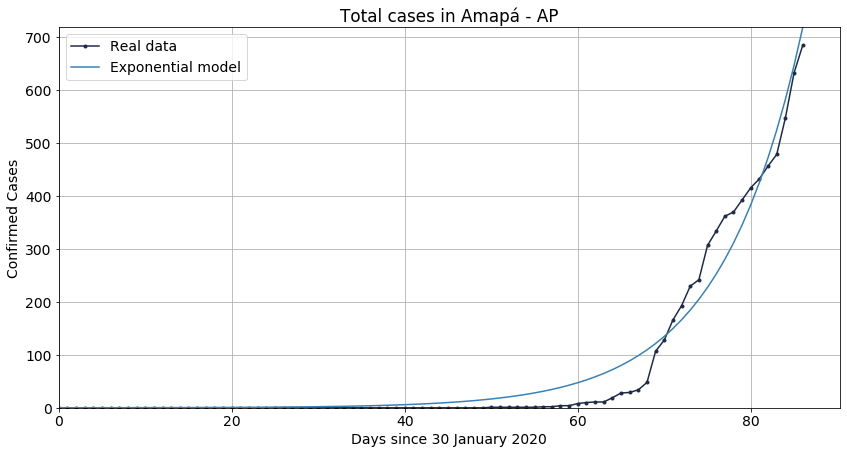

Expected final values: end of spread in 152 days with 1747.106 cases in MG
Next number of confirmed is 1741.614 in MG


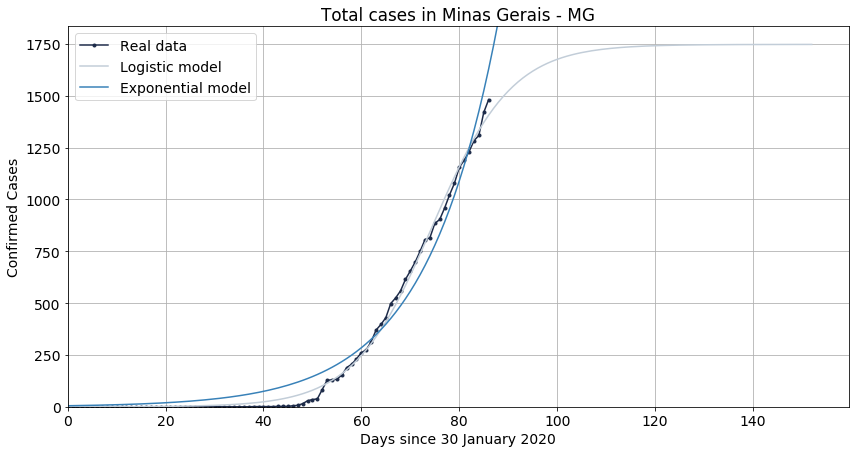

Next number of confirmed is 912.638 in RN


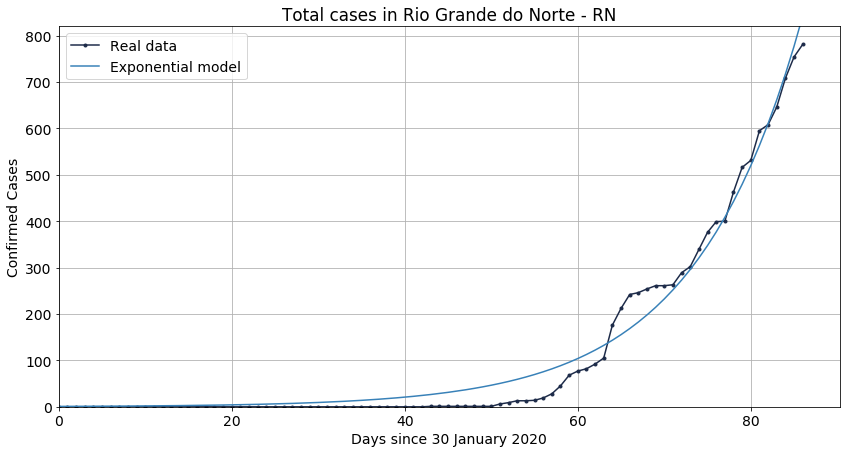

Next number of confirmed is 338.025 in PI


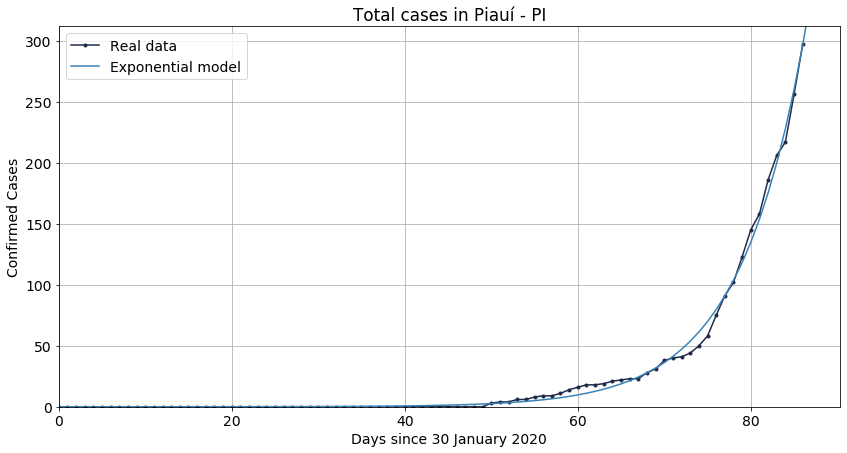

Expected final values: end of spread in 154 days with 24343.794 cases in SP
Next number of confirmed is 22678.98 in SP


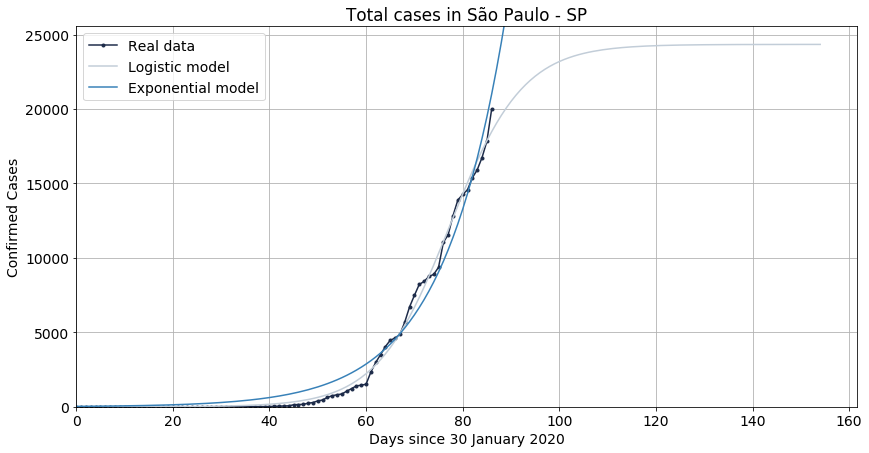

Next number of confirmed is 500.488 in PB


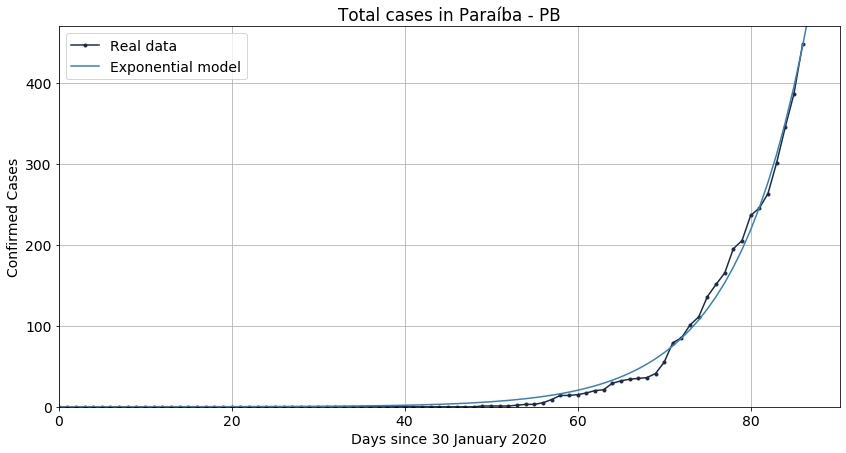

Next number of confirmed is 609.426 in GO


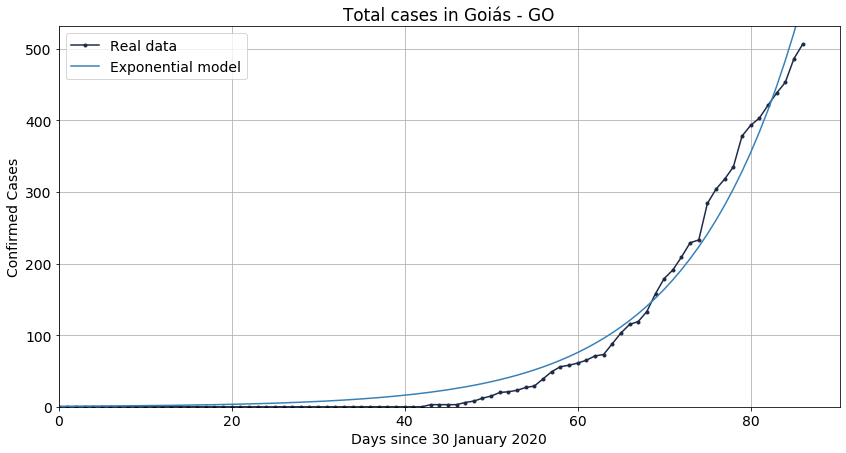

Expected final values: end of spread in 143 days with 1144.316 cases in DF
Next number of confirmed is 1210.708 in DF


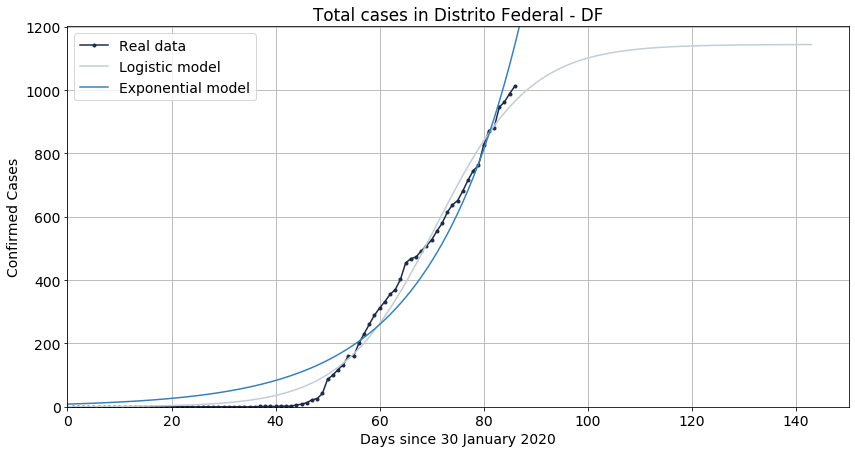

Next number of confirmed is 289.287 in AC


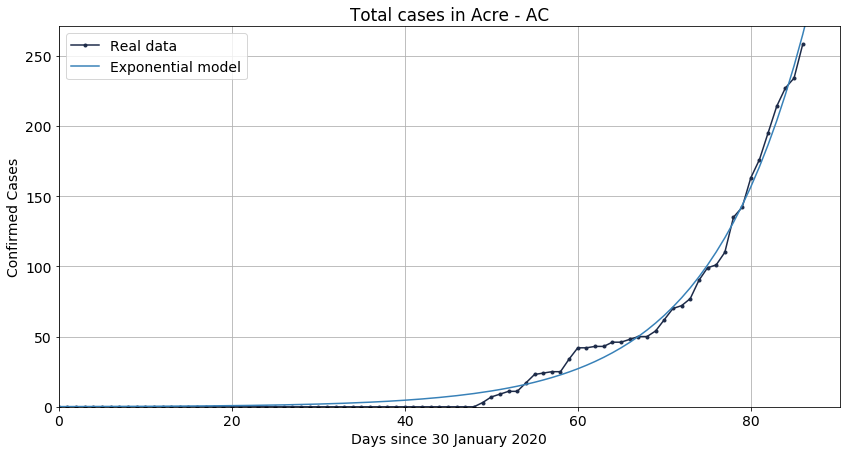

Expected final values: end of spread in 119 days with 1187.307 cases in PR
Next number of confirmed is 1444.75 in PR


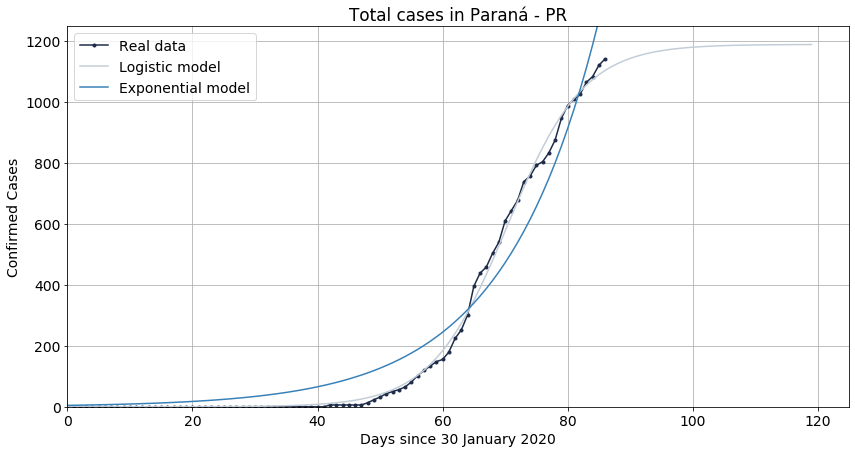

Expected final values: end of spread in 131 days with 3506.314 cases in MA
Next number of confirmed is 2580.523 in MA


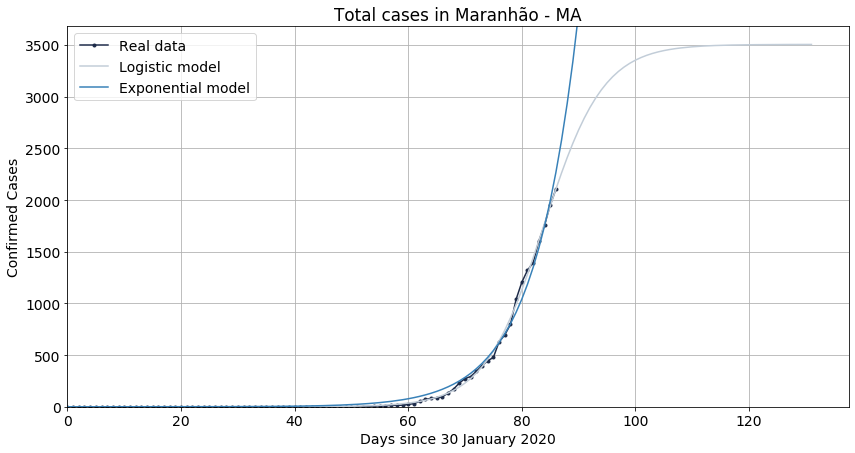

Expected final values: end of spread in 164 days with 6290.154 cases in AM
Next number of confirmed is 3961.884 in AM


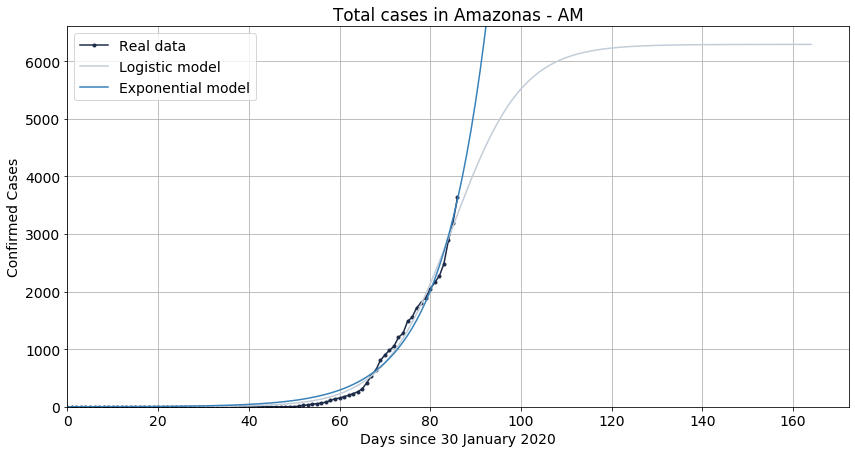

Expected final values: end of spread in 138 days with 7224.35 cases in PE
Next number of confirmed is 5286.642 in PE


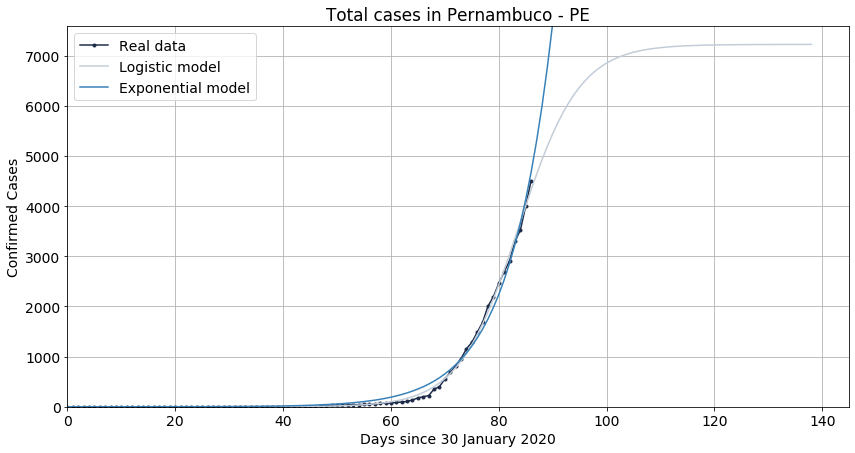

Expected final values: end of spread in 184 days with 7831.683 cases in BA
Next number of confirmed is 2347.793 in BA


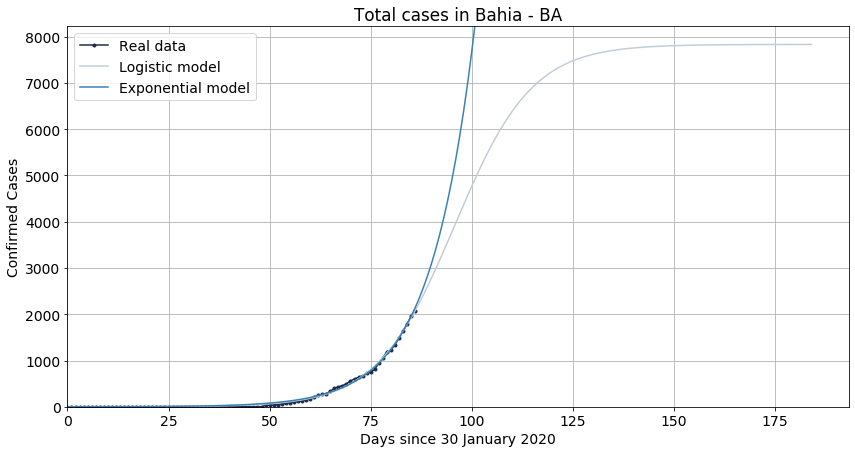

Expected final values: end of spread in 142 days with 2151.022 cases in ES
Next number of confirmed is 1914.042 in ES


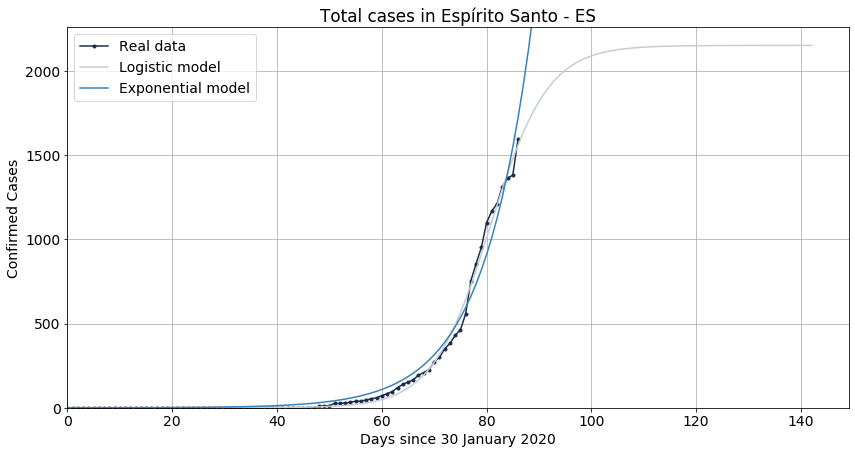

Next number of confirmed is 51.961 in TO


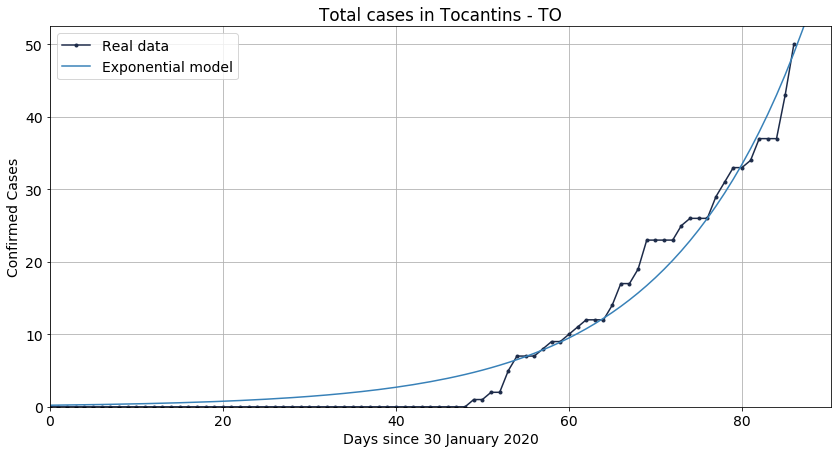

Expected final values: end of spread in 119 days with 1300.695 cases in SC
Next number of confirmed is 1498.54 in SC


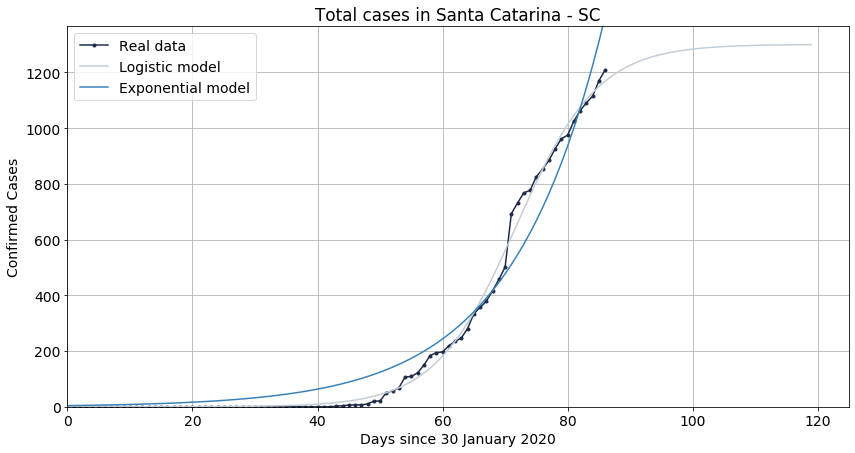

In [22]:
plt.grid(True)
plt.rcParams['figure.figsize'] = [14, 7]

estados = dfs["estado"].unique()

for e in estados :
    df_e = df_UF.loc[df_UF.iloc[:,0] == e, :].iloc[:, [1, 2]]
    pop = brasil.at[brasil['UF'].eq(e).idxmax(),'População']
    uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Unidade da Federação"]
    x = list(df_e.iloc[:, 0])
    y = list(df_e.iloc[:, 1])

    plt.grid(True)
    plt.rcParams['figure.figsize'] = [14, 7]

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

    exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df_e.index.size))
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                                  exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

    if max(y) > 1000 :
        logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 0.4 * pop])
        logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                            logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

        pred_x = list(range(max(x), logistic_sol))

        # Predicted logistic curve
        plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                              for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
        
        plt.xlim(0, max(pred_x) * 1.05)
        plt.ylim(0, logistic_fit[0][2] * 1.05)
        print("Expected final values: end of spread in " + str(max(pred_x)) + " days with " + str(round(logistic_fit[0][2], 3)) + " cases in " + e)
        
    else :
        plt.xlim(0, max(x) * 1.05)
        plt.ylim(0, max(y) * 1.05)

    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")
    
    print("Next number of confirmed is "+ str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3)) + " in " + e)
    
    plt.title("Total cases in " + uf + ' - ' + e)
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Confirmed Cases")
    plt.show()        

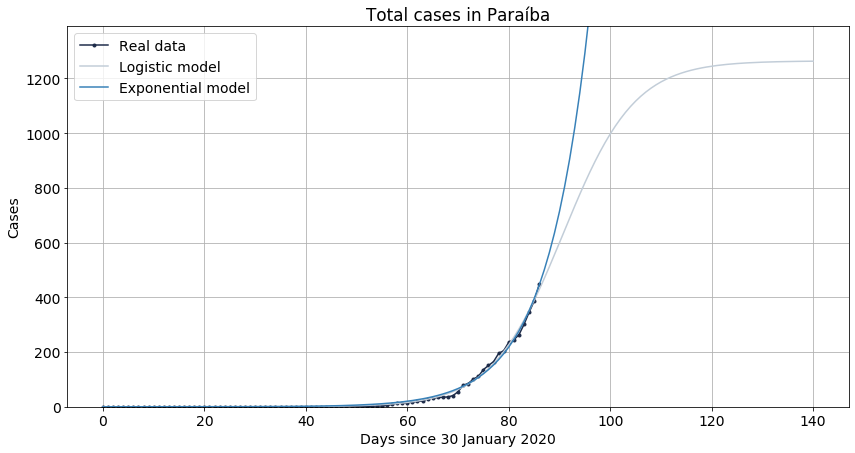

In [25]:
#debugging

est = 'PB'

df_PE = df_UF.loc[df_UF.iloc[:,0] == est, :].iloc[:, [1, 2]]
pop = brasil.at[brasil['UF'].eq(est).idxmax(),'População']
y = list(df_PE.iloc[:, 1])

plt.grid(True)

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 0.4 * pop])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

pred_x = list(range(max(x), logistic_sol))

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total cases in " + brasil.at[brasil['UF'].eq(est).idxmax(), "Unidade da Federação"])
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()